In [23]:
import searchnets.data
import searchnets.test

In [4]:
from configparser import ConfigParser
configfile = '/home/bart/Documents/repos/L2M/visual-search-nets/data/experiment_1/configs/searchnets_feature_search_alexnet.ini'

config = ConfigParser()
config.read(configfile)

['/home/bart/Documents/repos/L2M/visual-search-nets/data/experiment_1/configs/searchnets_feature_search_alexnet.ini']

Make new datasets with differing discriminability of target and distractors

In [21]:
for num in [51, 102, 153, 204]:
    config['DATA']['TRAIN_DIR'] = f'../../data/experiment_1/visual_search_stimuli/searchstims_feature_{num}_alexnet'
    config['DATA']['GZ_FILENAME'] = f'../../data/experiment_1/data_prepd_for_nets/feature_search_{num}_alexnet_data.gz'
    config['DATA']['TRAIN_SIZE'] = '400'
    config['DATA']['VALIDATION_SIZE'] = '200'
    searchnets.data.data(config)

loading images for training set
loading images for validation set
loading images for test set
loading images for training set
loading images for validation set
loading images for test set
loading images for training set
loading images for validation set
loading images for test set
loading images for training set
loading images for validation set
loading images for test set


Get accuracy on test set using new datasets

In [25]:
for num in [51, 102, 153, 204]:
    config['DATA']['TRAIN_DIR'] = f'../../data/experiment_1/visual_search_stimuli/searchstims_feature_{num}_alexnet'
    config['DATA']['GZ_FILENAME'] = f'../../data/experiment_1/data_prepd_for_nets/feature_search_{num}_alexnet_data.gz'
    config['DATA']['TRAIN_SIZE'] = '400'
    config['DATA']['VALIDATION_SIZE'] = '200'
    config['TRAIN']['MODEL_SAVE_PATH'] = '../../data/experiment_1/checkpoints/feature_search_alexnet_models/'
    config['TEST']['TEST_RESULTS_SAVE_PATH'] = f'../../data/experiment_1/results/feature_search_{num}_alexnet_models/'
    searchnets.test.test(config)

measuring accuracy on test set for alexnet model trained for 10 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:07<00:00, 19.67it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.58it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.95it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.96it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.25it/s]


measuring accuracy on test set for alexnet model trained for 50 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.27it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.35it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.60it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 24.02it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.36it/s]


measuring accuracy on test set for alexnet model trained for 200 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.09it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.77it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.51it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.44it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.48it/s]


measuring accuracy on test set for alexnet model trained for 400 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.35it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.28it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.09it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.79it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.21it/s]


measuring accuracy on test set for alexnet model trained for 800 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.94it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.59it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.83it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.92it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.62it/s]


measuring accuracy on test set for alexnet model trained for 10 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.30it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.70it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.88it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.69it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.47it/s]


measuring accuracy on test set for alexnet model trained for 50 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.74it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.51it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.56it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.47it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.79it/s]


measuring accuracy on test set for alexnet model trained for 200 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.52it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.67it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.81it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 29.04it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.77it/s]


measuring accuracy on test set for alexnet model trained for 400 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.68it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.54it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.88it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.91it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.88it/s]


measuring accuracy on test set for alexnet model trained for 800 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.52it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.81it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.72it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.73it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:04<00:00, 28.66it/s]


measuring accuracy on test set for alexnet model trained for 10 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.65it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 24.01it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 24.14it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 24.01it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.95it/s]


measuring accuracy on test set for alexnet model trained for 50 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.57it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.92it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.05it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.77it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.98it/s]


measuring accuracy on test set for alexnet model trained for 200 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:05<00:00, 23.65it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.82it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.45it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.03it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.57it/s]


measuring accuracy on test set for alexnet model trained for 400 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.05it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.67it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.97it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.97it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.43it/s]


measuring accuracy on test set for alexnet model trained for 800 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.25it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.48it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.26it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.24it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.69it/s]


measuring accuracy on test set for alexnet model trained for 10 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 23.45it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.76it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.98it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.81it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-10


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.35it/s]


measuring accuracy on test set for alexnet model trained for 50 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.72it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.40it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.91it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.79it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-50


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.84it/s]


measuring accuracy on test set for alexnet model trained for 200 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.99it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.64it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.43it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.53it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-200


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.79it/s]


measuring accuracy on test set for alexnet model trained for 400 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 21.98it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.11it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.15it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 21.75it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-400


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 21.74it/s]


measuring accuracy on test set for alexnet model trained for 800 epochs
Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_0/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.31it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_1/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.52it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_2/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.10it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_3/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.40it/s]


Loading model from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4
INFO:tensorflow:Restoring parameters from ../../data/experiment_1/checkpoints/feature_search_alexnet_models/net_number_4/alexnet-model.ckpt-800


predicting target present/absent for batch 140 of 141: 100%|██████████| 141/141 [00:06<00:00, 22.69it/s]


munging

In [26]:
import joblib
acc_by_epoch = {}

epoch_list = [10, 50, 200, 400, 800]
for epochs in epoch_list:
    acc_by_diff = {}
    for num in [0, 51, 102, 153, 204]:       
        if num == 0:
            test_results_save_path = f'../../data/experiment_1/results/feature_search_alexnet_models/test_alexnet_trained_{epochs}_epochs.gz'
        else:    
            test_results_save_path = f'../../data/experiment_1/results/feature_search_{num}_alexnet_models/test_alexnet_trained_{epochs}_epochs.gz'

        test_results = joblib.load(test_results_save_path)
        acc_by_diff[num]= test_results['acc_per_set_size_per_model']
    acc_by_epoch[epochs] = acc_by_diff

set_sizes = [1,2,4,8]
discrim_nums = [204, 153, 102, 51, 0]  # from least to most discriminable
subjects_by_epochs = {}
num_subjects = 5  # each trained neural net is a 'subject' in our psychophys experiment; what we called a "replicate" when repeating training before

for epochs in epoch_list:
    subjects = {}
    for subject_ind in range(num_subjects):
        acc_by_discrim_by_set_size = {set_size:[] for set_size in set_sizes}
        for set_size_ind, set_size in enumerate(set_sizes):
            for num in discrim_nums:
                acc_arr = acc_by_epoch[epochs][num]
                this_acc = acc_arr[subject_ind, set_size_ind]
                acc_by_discrim_by_set_size[set_size].append(this_acc)
        subjects[subject_ind] = acc_by_discrim_by_set_size
    subjects_by_epochs[epochs] = subjects

fit a psychometric function

In [65]:
from collections import namedtuple

import numpy as np
import scipy
from scipy.optimize import curve_fit

FitParams = namedtuple('FitParams', ['params', 'mcov'])

discrim_pct = (255 - np.asarray(discrim_nums)) / 255

def pf(x, alpha, beta):
    """psychometric function"""
    return 1. / (1 + np.exp(-(x - alpha) / beta))

In [57]:
fits_by_subject_by_epoch = {}
par0 = np.asarray([0., 1.])  # use some good starting values, reasonable default is [0., 1.]

for epochs in epoch_list:
    subjects = {}
    for subject_ind in range(num_subjects):
        fits_by_set_size = {}
        for set_size_ind, set_size in enumerate(set_sizes):
            p2 = subjects_by_epochs[epochs][subject_ind][set_size]
            par, mcov = curve_fit(pf, discrim_pct, p2, par0)
            fit_params = FitParams(par, mcov)
            fits_by_set_size[set_size] = fit_params
        subjects[subject_ind] = fits_by_set_size
    fits_by_subject_by_epoch[epochs] = subjects

Do a sanity check; what do the fits look like?

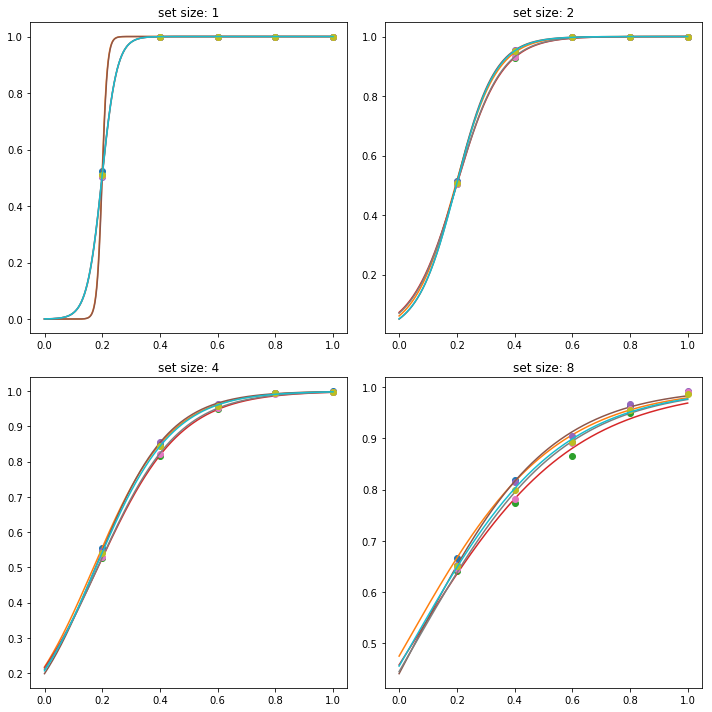

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

epoch_for_plot = 800
subject_for_plot = 1
d_range = np.linspace(0,1,1000)

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10,10)
ax = ax.ravel()
for set_size_ind, set_size in enumerate(set_sizes):
    for subject_ind in range(num_subjects):
        p2 = subjects_by_epochs[epoch_for_plot][subject_ind][set_size]
        ax[set_size_ind].plot(discrim_pct, p2, marker='o', linestyle='None')
        params = fits_by_subject_by_epoch[epoch_for_plot][subject_ind][set_size].params
        ax[set_size_ind].plot(d_range, pf(d_range, params[0], params[1]))
        ax[set_size_ind].set_title(f"set size: {set_size}")

fig.tight_layout()

In [88]:
TH = 0.75  # we want to look for set size effects at a constant difference threshold

diff_ths = {}  # difference thresholds
for epochs in epoch_list:
    subjects = {}
    for subject_ind in range(num_subjects):
        diff_th_by_set_size = []
        for set_size_ind, set_size in enumerate(set_sizes):
            params = fits_by_subject_by_epoch[epochs][subject_ind][set_size].params
            y = pf(d_range, params[0], params[1])
            th_ind = np.argmin(np.abs(y - TH))  # where (on x-axis) did subject have 75% accuracy for this set size?
            diff_th_by_set_size.append(d_range[th_ind])
        subjects[subject_ind] = diff_th_by_set_size
    diff_ths[epochs] = subjects

diff_ths_log = {}  # difference thresholds
for epochs in epoch_list:
    subjects = {}
    for subject_ind in range(num_subjects):
        diff_th_log_by_set_size = []
        for set_size_ind, set_size in enumerate(set_sizes):
            diff_th_log_by_set_size.append(np.log(diff_ths[epochs][subject_ind][set_size_ind]))
        subjects[subject_ind] = diff_th_log_by_set_size
    diff_ths_log[epochs] = subjects

/home/bart/anaconda3/envs/searchnets/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


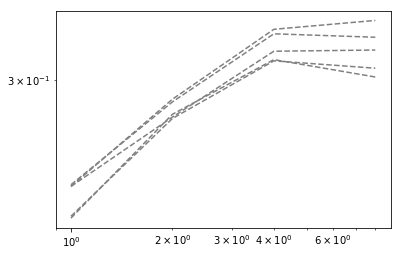

In [86]:
epoch_for_plot = 800

fig, ax = plt.subplots()
subjects_for_plot = diff_ths[epochs]
for subject_ind in range(num_subjects):
    ax.loglog(set_sizes, subjects_for_plot[subject_ind], color='grey', linestyle='--')

In [103]:
log_set_size = np.log(set_sizes)
from scipy import stats

mn_diff_ths_epochs = {}
linregress_epochs = {}
for epochs in epoch_list:
    diff_ths_log_this_epoch = []
    for subject_ind in range(num_subjects):
        diff_ths_log_this_epoch.append(diff_ths_log[epochs][subject_ind])
    mn_diff_ths_epochs[epochs] = np.asarray(diff_ths_log_this_epoch).mean(axis=0)
    linregress_epochs[epochs] = stats.linregress(log_set_size, mn_diff_ths_epochs[epochs])

{10: array([-1.48451227, -0.96780571, -0.48155254, -0.12041001]),
 50: array([-1.46959202, -1.27548533, -1.177977  , -0.95876582]),
 200: array([-1.49325645, -1.28014404, -1.15734329,        -inf]),
 400: array([-1.51840266, -1.28904971, -1.16740552,        -inf]),
 800: array([-1.51301729, -1.28295776, -1.11799002, -1.12743968])}